# Preparing logistic_DEAD_CAD_noMI SumStats for GWAS Catalog

This notebook serves to inspect `SumStats for GENIUS-CHD`, and proceses the meta-analysis GWAS data for sharing through *GWAS Catalog*.

Phenotypes: 
- `META_logistic_DEAD_CAD_noMI`
- `META_logistic_DEAD_CAD_MI`
- `META_logistic_DEAD_ALL`
- `META_logistic_CVDEAD_ALL`
- `META_cox_DEAD_ALL`
- `META_cox_CHDDEAD_MI_CAD_MI`

This notebooks handles **logistic_DEAD_CAD_noMI** summary statistics only.

## Import necessary libraries

In [1]:
# Function to check for installation of required packages
def check_install_package(package_name):
    try:
        importlib.import_module(package_name)
    except ImportError:
        print(f'{package_name} is not installed. Installing it now...')
        subprocess.check_call(['pip', 'install', package_name])

import os
import glob
import importlib
import subprocess
import sys

# argument parsing
import argparse

# get date and time
from datetime import datetime

# Pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool
check_install_package('pandas')
import pandas as pd

# pyarrow is supperior to loading parquet files
check_install_package('pyarrow')
import pyarrow as pa
import pyarrow.parquet as pq

# polars is a fast dataframe library
check_install_package('polars')
import polars as pl

# for statistical analysis
check_install_package('scipy')
from scipy import stats
import numpy as np

# scientific colourmaps
# https://www.fabiocrameri.ch/ws/media-library/8c4b111121ff448e843dfef9220bf613/readme_scientificcolourmaps.pdf
check_install_package('cmcrameri')
import cmcrameri as ccm
from cmcrameri import cm

# for plotting
check_install_package('matplotlib')
import matplotlib
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

# use Seaborn for visualisations
check_install_package('seaborn')
import seaborn as sns

# for handling GWAS data
import gwaslab as gl

Creating directories for plots

In [2]:
# Create directories for the GWAS data and the reference data
import os
from subprocess import check_output

# set some general defaults
# META_logistic_DEAD_CAD_noMI.all.clean.txt.gz
SUBSTUDY_PHENO = "META_logistic_DEAD_CAD_noMI"
# META_logistic_DEAD_CAD_MI.all.clean.txt.gz
# SUBSTUDY_PHENO = "META_logistic_DEAD_CAD_MI"
# META_logistic_DEAD_ALL.all.clean.txt.gz
# SUBSTUDY_PHENO = "META_logistic_DEAD_ALL"
# META_logistic_CVDEAD_ALL.all.clean.txt.gz
# SUBSTUDY_PHENO = "META_logistic_CVDEAD_ALL"
# META_cox_DEAD_ALL.all.clean.txt.gz
# SUBSTUDY_PHENO = "META_cox_DEAD_ALL"
# META_cox_CHDDEAD_MI_CAD_MI.all.clean.txt.gz
# SUBSTUDY_PHENO = "META_cox_CHDDEAD_MI_CAD_MI"

POPULATION = "EUR"

PHENOTYPE = "logistic_DEAD_CAD_noMI"

REF_1KG = "1kg_eur_hg19"

# general plotting directory
PLOTS_loc = "PLOTS"

# Check if the directory exists
if not os.path.exists(PLOTS_loc):
    # If it doesn't exist, create it
    os.makedirs(PLOTS_loc)

# regional association plots directory
REG_PLOTS_loc = PLOTS_loc + "/Regional_Association_Plots"

# Check if the directory exists
if not os.path.exists(REG_PLOTS_loc):
    # If it doesn't exist, create it
    os.makedirs(REG_PLOTS_loc)

# Reference data directory
REF_loc = "/Users/slaan3/PLINK/references"
print("Checking contents of the reference directory:")
print(check_output(["ls", os.path.join(REF_loc)]).decode("utf8"))

# GWAS data directory
GWAS_RES_loc = "/Users/slaan3/Library/CloudStorage/OneDrive-SharedLibraries-UMCUtrecht/GENIUS-CHD - General/#RESULTS/META_results/"
print("Checking contents of the GWAS results directory:")
print(check_output(["ls", os.path.join(GWAS_RES_loc)]).decode("utf8"))

GWAS_DATASETS_loc = "/Users/slaan3/PLINK/_GWAS_Datasets/"
print("Checking contents of the GWAS Datasets directory:")
print(check_output(["ls", os.path.join(GWAS_DATASETS_loc)]).decode("utf8"))

# Check if the directory exists
if not os.path.exists("GWASCatalog"):
    # If it doesn't exist, create it
    os.makedirs("GWASCatalog")

# GWAS Catalog directory
GWASCatalog_loc = os.path.join("GWASCatalog")

Checking contents of the reference directory:
1000G
HRC_r1_1_2016
HRCr11_1000Gp3v5
dbSNP
tcga

Checking contents of the GWAS results directory:
META_cox_CHDDEAD_MI_CAD_MI
META_cox_DEAD_ALL
META_logistic_CVDEAD_ALL
META_logistic_DEAD_ALL
META_logistic_DEAD_CAD_MI
META_logistic_DEAD_CAD_noMI

Checking contents of the GWAS Datasets directory:
_AAAgen
_BloodPressure
_CARDIoGRAM
_CHARGE_CAC
_CHARGE_cIMT_PlaquePresence
_DIAGRAM
_IMPROVE_OLINK
_ISGC
_LIPIDS
_PGC
_SCALLOP
_SMCs
_SiGN
_VERTIGO
_cojo
_magma



## Loading data

Loading the different datasets.

In [3]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

print(check_output(
    ["ls", os.path.join(GWAS_RES_loc, SUBSTUDY_PHENO)]).decode("utf8"))

META_logistic_DEAD_CAD_noMI.2018_CAD_SNPs.txt
META_logistic_DEAD_CAD_noMI.all.cardiogram2022.txt
META_logistic_DEAD_CAD_noMI.all.clean.txt.gz
META_logistic_DEAD_CAD_noMI.cardiogram24snps.txt
META_logistic_DEAD_CAD_noMI.significant.clean.txt
META_logistic_DEAD_CAD_noMI_plots.clean.manhattan.png
META_logistic_DEAD_CAD_noMI_plots.clean.qqplot_impq.pdf
META_logistic_DEAD_CAD_noMI_plots.clean.qqplot_maf.pdf
META_logistic_DEAD_CAD_noMI_plots.manhattan.png
META_logistic_DEAD_CAD_noMI_plots.qqplot_impq.pdf
META_logistic_DEAD_CAD_noMI_plots.qqplot_maf.pdf



# Million Hearts

We load in the GWAS on CAD. This was already parsed in the `cox_DEAD_ALL` notebook, so we load the pickle here.

In [4]:
# import gwaslab as gl

# gl.dump_pickle(
#     cad_data_sumstats,
#     os.path.join(
#         GWASCatalog_loc + "/MILLIONHEARTS.b37.gwaslab.pkl",
#     ),
#     overwrite=True,
# )

cad_data_sumstats = gl.load_pickle(
    os.path.join(GWASCatalog_loc + "/MILLIONHEARTS.b37.gwaslab.pkl")
)

Thu Nov  2 16:32:34 2023 Loaded dumped Sumstats object from :  GWASCatalog/MILLIONHEARTS.b37.gwaslab.pkl


# logistic_DEAD_CAD_noMI


In [5]:
# read in data
# https://stackoverflow.com/questions/33813815/how-to-read-a-parquet-file-into-pandas-dataframe

import polars as pl

temp = pl.read_csv(
    source=os.path.join(
        GWAS_RES_loc
        + SUBSTUDY_PHENO
        + "/META_"
        + PHENOTYPE
        + ".all.clean.txt.gz",  # META_logistic_DEAD_CAD_MI.all.clean.txt.gz
    ),
    has_header=True,
    separator=" ",
    ignore_errors=False,
    # n_rows=1000, # for debugging
    quote_char=None,
    # necessary to fix issues with missing values when reading data
    null_values=["NA"],
    # There is an error at import (from temp to pandas()):
    # Could not parse `X` as dtype `i64` at column 'CHR' (column number 2)
    # https://stackoverflow.com/questions/75797640/how-to-specify-column-types-in-python-polars-read-csv
    # https://stackoverflow.com/questions/71790235/switching-between-dtypes-within-a-dataframe
    # https://pola-rs.github.io/polars/user-guide/concepts/data-types/
    dtypes={"CHR": pl.Utf8},
)
# change polars dataframe to pandas dataframe
gwas_data = temp.to_pandas()
del temp

### Inspection of data

Here we do a quick check on what is what in the data.

#### Heads

Printing head of data.

In [6]:
gwas_data.head()

,SNP,CHR,POS,HAPMAP_A1_FREQ,CODED_ALLELE,NONCODED_ALLELE,CODED_ALLELE_FREQ,N_EFF,P_SQRTN,BETA_FIXED,SE_FIXED,P_FIXED,P_RANDOM,DF,P_COCHRANS_Q,I_SQUARED,DIRECTIONS,GENES_1000KB,NEAREST_GENE,CAVEAT
0,1:662622,1,662622,0.145188,A,G,0.149,29682.7,0.96746,0.0038,0.0319,0.90539,0.88190,6,0.30299,16.6,...+.++..--++,"RNF223,MRPL20,PLEKHN1,UBE2J2,CDK11A,TMEM240,AL...",OR4F16,None
1,1:693731,1,693731,0.141858,G,A,0.156,31014.7,0.80306,-0.0033,0.0310,0.91515,0.97931,7,0.28027,18.9,...+.-+-.---+,"RNF223,MRPL20,PLEKHN1,UBE2J2,CDK11A,TMEM240,AL...",AL669831.1,None
2,1:715265,1,715265,0.028472,T,C,0.038,8377.5,0.50374,0.0726,0.1530,0.63505,0.65942,5,0.36533,8.0,.+.+-.-...+.+,"RNF223,MRPL20,PLEKHN1,UBE2J2,CDK11A,TMEM240,AL...",AL669831.1,None
3,1:715367,1,715367,0.028472,G,A,0.036,8056.3,0.64463,0.0519,0.1563,0.73967,0.73967,5,0.44404,0.0,.+.+-.-...+.+,"RNF223,MRPL20,PLEKHN1,UBE2J2,CDK11A,TMEM240,AL...",AL669831.1,None
4,1:719914,1,719914,0.027639,G,C,0.038,8431.2,0.47886,0.0727,0.1527,0.63407,0.66653,5,0.34383,11.2,.+.+-.-...+.+,"RNF223,MRPL20,PLEKHN1,UBE2J2,CDK11A,TMEM240,AL...",AL669831.1,None


#### Shapes

Printing shapes of data.

In [7]:
print("Printing shape of data:\n", gwas_data.shape)

Printing shape of data:
 (9523593, 20)


#### Columns

Printing columns of data.

In [8]:
print("Printing columns of data:\n", gwas_data.columns)

Printing columns of data:
 Index(['SNP', 'CHR', 'POS', 'HAPMAP_A1_FREQ', 'CODED_ALLELE',
       'NONCODED_ALLELE', 'CODED_ALLELE_FREQ', 'N_EFF', 'P_SQRTN',
       'BETA_FIXED', 'SE_FIXED', 'P_FIXED', 'P_RANDOM', 'DF', 'P_COCHRANS_Q',
       'I_SQUARED', 'DIRECTIONS', 'GENES_1000KB', 'NEAREST_GENE', 'CAVEAT'],
      dtype='object')


#### Info

Printing info of Women-only data.

In [9]:
print("Printing info of data:\n", gwas_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9523593 entries, 0 to 9523592
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   SNP                object 
 1   CHR                object 
 2   POS                int64  
 3   HAPMAP_A1_FREQ     float64
 4   CODED_ALLELE       object 
 5   NONCODED_ALLELE    object 
 6   CODED_ALLELE_FREQ  float64
 7   N_EFF              float64
 8   P_SQRTN            float64
 9   BETA_FIXED         float64
 10  SE_FIXED           float64
 11  P_FIXED            float64
 12  P_RANDOM           float64
 13  DF                 int64  
 14  P_COCHRANS_Q       float64
 15  I_SQUARED          float64
 16  DIRECTIONS         object 
 17  GENES_1000KB       object 
 18  NEAREST_GENE       object 
 19  CAVEAT             object 
dtypes: float64(10), int64(2), object(8)
memory usage: 1.4+ GB
Printing info of data:
 None


#### Column statistics

Getting some per column summary statistics of Women-only data.

In [10]:
print("Printing describe of data:\n", gwas_data.describe())

Printing describe of data:
                 POS  HAPMAP_A1_FREQ  CODED_ALLELE_FREQ         N_EFF  \
count  9.523593e+06    9.471654e+06       9.523593e+06  9.523593e+06   
mean   7.851660e+07    2.572361e-01       2.571181e-01  3.745410e+04   
std    5.637822e+07    2.528644e-01       2.624229e-01  1.322209e+04   
min    3.020000e+02    1.665000e-04       1.000000e-02  1.513100e+03   
25%    3.218868e+07    4.911750e-02       4.100000e-02  3.315740e+04   
50%    6.890819e+07    1.666670e-01       1.530000e-01  4.102930e+04   
75%    1.142746e+08    4.044290e-01       4.090000e-01  4.778390e+04   
max    2.492331e+08    1.000000e+00       9.900000e-01  4.825580e+04   

            P_SQRTN    BETA_FIXED      SE_FIXED       P_FIXED      P_RANDOM  \
count  9.523593e+06  9.523593e+06  9.523593e+06  9.523593e+06  9.523593e+06   
mean   5.028856e-01  7.918268e-03  5.566045e-02  4.989643e-01  5.208366e-01   
std    2.880670e-01  8.056328e-02  6.028943e-02  2.894627e-01  2.837055e-01   
min    

### Basic visualisations

Here we plot histograms of allele frequencies, effect, and sample size .

#### Sampling from the data
Here we provide an example on how to take a sample of n=800,000 rows, representing ±10% of the data, for easy plotting. This should be representative for most things we are interested in.

In [11]:
# example code to get a sample

# gwas_data_sample = gwas_data.sample(800000)

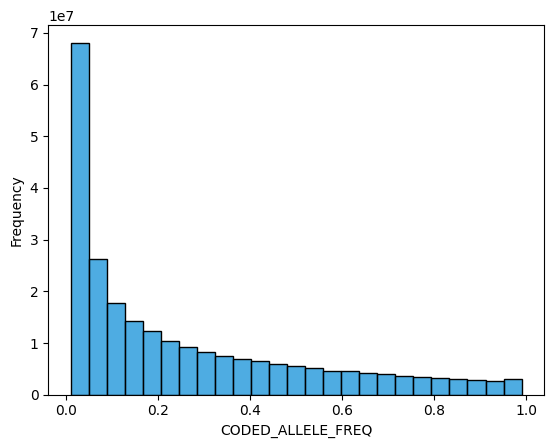

In [12]:
import seaborn as sns

sns.histplot(
    data=gwas_data,  # gwas_combo_sample,
    x="CODED_ALLELE_FREQ",
    bins=25,
    kde=False,
    stat="frequency",
    color="#1290D9",
)

# plt.savefig(
#     os.path.join(PLOTS_loc, "histogram.EAF.WOMEN." + POPULATION + ".png"),
#     dpi=300,
#     bbox_inches="tight",
#     format="png",
# )
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.EAF." + PHENOTYPE + ".pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

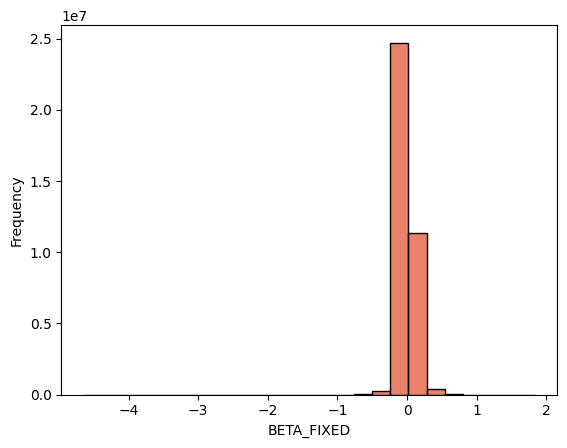

In [13]:
sns.histplot(
    data=gwas_data,  # gwas_combo_sample,
    x="BETA_FIXED",
    bins=25,
    kde=False,
    stat="frequency",
    color="#E55738",
)

# plt.savefig(
#     os.path.join(PLOTS_loc, "histogram.effect.WOMEN." + POPULATION + ".png"),
#     dpi=300,
#     bbox_inches="tight",
#     format="png",
# )
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.effect." + PHENOTYPE + ".pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

### SumStats quality control

Here we first check and fix headers, and contents of the SumStats object.

First, we load the data and inspect it using `GWASLab`. Note that for this to work, some column types need to be adjusted.

```
 0   SNP                object 
 1   CHR                object 
 2   POS                int64  
 3   HAPMAP_A1_FREQ     float64
 4   CODED_ALLELE       object 
 5   NONCODED_ALLELE    object 
 6   CODED_ALLELE_FREQ  float64
 7   N_EFF              float64
 8   P_SQRTN            float64
 9   BETA_FIXED         float64
 10  SE_FIXED           float64
 11  P_FIXED            float64
 12  P_RANDOM           float64
 13  DF                 int64  
 14  P_COCHRANS_Q       float64
 15  I_SQUARED          float64
 16  DIRECTIONS         object 
 17  GENES_1000KB       object 
 18  NEAREST_GENE       object 
 19  CAVEAT             object 
 ```

In [14]:
gwas_data[["CHR"]] = gwas_data[["CHR"]].astype("Int64")

In [15]:
# gwas_data[["BP"]] = gwas_data[["BP"]].astype("Int64")

In [16]:
# create new SNPID column based on chromosome, position, and alleles
# down the road we need an SNPID column to merge with the reference data and which does not contain 'ID' because this is not correctly interpreted by GWASLab
gwas_data["SNPID"] = (
    gwas_data["CHR"].astype(str)
    + ":"
    + gwas_data["POS"].astype(str)
    + ":"
    + gwas_data["NONCODED_ALLELE"].astype(str)
    + ":"
    + gwas_data["CODED_ALLELE"].astype(str)
)

# from an *.out file at /hpc/dhl_ec/svanderlaan/projects/sign/vonberg_joanna/2.Age.of.onset/linreg_aoo_unrestricted_bolt/amr.everything.butwhi/xx.group
# gwas_data["N"] = 5344

In [17]:
gwas_data.head()

,SNP,CHR,POS,HAPMAP_A1_FREQ,CODED_ALLELE,NONCODED_ALLELE,CODED_ALLELE_FREQ,N_EFF,P_SQRTN,BETA_FIXED,...,P_FIXED,P_RANDOM,DF,P_COCHRANS_Q,I_SQUARED,DIRECTIONS,GENES_1000KB,NEAREST_GENE,CAVEAT,SNPID
0,1:662622,1,662622,0.145188,A,G,0.149,29682.7,0.96746,0.0038,...,0.90539,0.88190,6,0.30299,16.6,...+.++..--++,"RNF223,MRPL20,PLEKHN1,UBE2J2,CDK11A,TMEM240,AL...",OR4F16,None,1:662622:G:A
1,1:693731,1,693731,0.141858,G,A,0.156,31014.7,0.80306,-0.0033,...,0.91515,0.97931,7,0.28027,18.9,...+.-+-.---+,"RNF223,MRPL20,PLEKHN1,UBE2J2,CDK11A,TMEM240,AL...",AL669831.1,None,1:693731:A:G
2,1:715265,1,715265,0.028472,T,C,0.038,8377.5,0.50374,0.0726,...,0.63505,0.65942,5,0.36533,8.0,.+.+-.-...+.+,"RNF223,MRPL20,PLEKHN1,UBE2J2,CDK11A,TMEM240,AL...",AL669831.1,None,1:715265:C:T
3,1:715367,1,715367,0.028472,G,A,0.036,8056.3,0.64463,0.0519,...,0.73967,0.73967,5,0.44404,0.0,.+.+-.-...+.+,"RNF223,MRPL20,PLEKHN1,UBE2J2,CDK11A,TMEM240,AL...",AL669831.1,None,1:715367:A:G
4,1:719914,1,719914,0.027639,G,C,0.038,8431.2,0.47886,0.0727,...,0.63407,0.66653,5,0.34383,11.2,.+.+-.-...+.+,"RNF223,MRPL20,PLEKHN1,UBE2J2,CDK11A,TMEM240,AL...",AL669831.1,None,1:719914:C:G


In [18]:
# gwas_data.rename(columns={"SNP": "VariantID"}, inplace=True)

### Converting to GWASLab object

Here we are ready to load the data and inspect it using `GWASLab`. 

In [19]:
import gwaslab as gl

# Specify the columns:
gwas_data_sumstats = gl.Sumstats(
    gwas_data,
    snpid="SNPID",
    # rsid="RSID", # not available
    chrom="CHR",
    pos="POS",
    ea="CODED_ALLELE",
    nea="NONCODED_ALLELE",
    eaf="CODED_ALLELE_FREQ",
    beta="BETA_FIXED",
    se="SE_FIXED",
    p="P_FIXED",
    # direction="Direction",  # only for meta-GWAS
    n="N_EFF",
    # info="Info", # not available
    other=[
        "DF",
        "DIRECTIONS",
        "P_COCHRANS_Q",
        "I_SQUARED",
        "CAVEAT",
    ],
    build="19",
    verbose=True,
)

Thu Nov  2 16:33:16 2023 GWASLab v3.4.29 https://cloufield.github.io/gwaslab/
Thu Nov  2 16:33:16 2023 (C) 2022-2023, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
Thu Nov  2 16:33:16 2023 Start to initiate from pandas DataFrame ...
Thu Nov  2 16:33:21 2023  -Reading columns          : SNPID,N_EFF,CODED_ALLELE,CHR,BETA_FIXED,P_FIXED,SE_FIXED,DF,POS,CODED_ALLELE_FREQ,DIRECTIONS,P_COCHRANS_Q,I_SQUARED,CAVEAT,NONCODED_ALLELE
Thu Nov  2 16:33:21 2023  -Renaming columns to      : SNPID,N,EA,CHR,BETA,P,SE,DF,POS,EAF,DIRECTIONS,P_COCHRANS_Q,I_SQUARED,CAVEAT,NEA
Thu Nov  2 16:33:21 2023  -Current Dataframe shape : 9523593  x  15
Thu Nov  2 16:33:23 2023  -Initiating a status column: STATUS ...
Thu Nov  2 16:33:26 2023 Start to reorder the columns...
Thu Nov  2 16:33:26 2023  -Current Dataframe shape : 9523593  x  16
Thu Nov  2 16:33:26 2023  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,STATUS,DF,DIRECTIONS,P_COCHRANS_Q,I_SQUARED,CAVEAT
Thu Nov  2 16:33:27 2023 Fini

In [20]:
gwas_data_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,STATUS,DF,DIRECTIONS,P_COCHRANS_Q,I_SQUARED,CAVEAT
0,1:662622:G:A,1,662622,A,G,0.149,0.0038,0.0319,0.905390,29682.7,1999999,6,...+.++..--++,0.30299,16.6,None
1,1:693731:A:G,1,693731,G,A,0.156,-0.0033,0.0310,0.915150,31014.7,1999999,7,...+.-+-.---+,0.28027,18.9,None
2,1:715265:C:T,1,715265,T,C,0.038,0.0726,0.1530,0.635050,8377.5,1999999,5,.+.+-.-...+.+,0.36533,8.0,None
3,1:715367:A:G,1,715367,G,A,0.036,0.0519,0.1563,0.739670,8056.3,1999999,5,.+.+-.-...+.+,0.44404,0.0,None
4,1:719914:C:G,1,719914,G,C,0.038,0.0727,0.1527,0.634070,8431.2,1999999,5,.+.+-.-...+.+,0.34383,11.2,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523588,22:50346321:G:T,22,50346321,T,G,0.018,0.0673,0.2455,0.784070,5916.7,1999999,2,.....++..-...,0.47466,0.0,not_unique_position
9523589,22:51001102:T:G,22,51001102,G,T,0.017,0.0092,0.2689,0.972600,5595.4,1999999,2,.....++..-...,0.72670,0.0,None
9523590,1:149343639:A:G,1,149343639,G,A,0.645,-0.1095,0.0952,0.250420,5251.8,1999999,2,......-+.-...,0.38913,0.0,None
9523591,14:106291576:C:T,14,106291576,T,C,0.587,-0.0483,0.1157,0.676480,4316.3,1999999,2,......--.+...,0.59993,0.0,None


In [21]:
gwas_data_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                      9523593   
         Column_num                                                        16   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,STATUS,DF...   
         Last_checked_time                           Thu Nov  2 16:33:28 2023   
MISSING  Missing_total                                                      0   
MAF      Common                                                       6706195   
         Low_frequency                                                2776910   
         Rare                                                               0   
P        Minimum                                                   1.7102e-08   
         Significant                                                        3   
         Suggestive                                                        53   
STATUS   1999999                                                      9523593   

                            Percentage  
Category Items                          
META     Row_num                   NaN  
         Column_num                NaN  
         Column_names              NaN  
         Last_checked_time         NaN  
MISSING  Missing_total            0.00  
MAF      Common                  70.42  
         Low_frequency           29.16  
         Rare                     0.00  
P        Minimum                  0.00  
         Significant              0.00  
         Suggestive               0.00  
STATUS   1999999                100.00

In [22]:
gwas_data_sumstats.lookup_status()

,Genome_Build,rsID&SNPID,CHR&POS,Stadardize&Normalize,Align,Panlidromic_SNP&Indel,Count,Percentage(%)
1999999,hg19,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,9523593,100.0


#### Intermediate cleaning

Here we cleanup the originally loaded data, to clear memory.

In [23]:
del gwas_data

#### Get reference data

We align the data to the reference genome, this will work for most common variants. Before that, we check which reference datasets are available, and get these.

In [24]:
# check references
gl.check_available_ref()

# {'1kg_eas_hg19': 'https://www.dropbox.com/s/lztaxqhy2o6dpxw/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
#  '1kg_eas_hg19_md5': 'c8c97434843c0da3113fc06879ead472',
#  '1kg_eas_hg19_tbi': 'https://www.dropbox.com/s/k9klefl8m9fcfo1/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
#  '1kg_eur_hg19': 'https://www.dropbox.com/s/1nbgqshknevseks/amr.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
#  '1kg_eur_hg19_md5': '734069d895009d38c2f962bfbb6fab52',
#  '1kg_eur_hg19_tbi': 'https://www.dropbox.com/s/vscvkrflh6fc5a0/amr.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
#  '1kg_eas_hg38': 'https://www.dropbox.com/s/3dstbbb1el9r3au/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
#  '1kg_eas_hg38_md5': 'f45e80bca9ef7b29e6b1832e6ac15375',
#  '1kg_eas_hg38_tbi': 'https://www.dropbox.com/s/vwnp5vd8dcqksn4/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?dl=1',
#  '1kg_eur_hg38': 'https://www.dropbox.com/s/z0mkehg17lryapv/amr.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
#  '1kg_eur_hg38_md5': '228d3285fa99132cc6321e2925e0768d',
#  '1kg_eur_hg38_tbi': 'https://www.dropbox.com/s/ze8g58x75x9qbf0/amr.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?dl=1',
#  '1kg_sas_hg19': 'https://www.dropbox.com/scl/fi/fubqvuj3p4ii4y35zknv8/SAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=5z50f66iltjchcaszznq5bczt&dl=1',
#  '1kg_sas_hg19_md5': 'e2d3f9e2e6580d05e877e9effd435c4e',
#  '1kg_sas_hg19_tbi': 'https://www.dropbox.com/scl/fi/icnmrnzee7ofdpx5l96tg/SAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=st8t88snby26q37rqi6zh5zck&dl=1',
#  '1kg_amr_hg19': 'https://www.dropbox.com/scl/fi/bxa4zfngsxsc38rhtiv8c/AMR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=ibcn8hb1n8n36j3u0jfzci267&dl=1',
#  '1kg_amr_hg19_md5': '68d3cdf01cbabdae6e74a07795fa881c',
#  '1kg_amr_hg19_tbi': 'https://www.dropbox.com/scl/fi/1zk16x7h4r89jurzwu05u/AMR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=b4cere4w38zvzyfitfge3r8n0&dl=1',
#  '1kg_sas_hg38': 'https://www.dropbox.com/scl/fi/jr3l5zz42py3kny2bccmj/SAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=x0t6tsy71jxzf021wfqdn8k5q&dl=1',
#  '1kg_sas_hg38_md5': 'e5d79bea1958aa50c23f618d342ccc83',
#  '1kg_sas_hg38_tbi': 'https://www.dropbox.com/scl/fi/02oia4ur5r7w9qgiuf6i9/SAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=00p9rxe0xzfs6hr1rg4d8oadm&dl=1',
#  '1kg_amr_hg38': 'https://www.dropbox.com/scl/fi/4t4tyuhzp78uyb6tgkroq/AMR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=p96gbs1tcdia31jnjv1b82kuz&dl=1',
#  '1kg_amr_hg38_md5': '229fbd610001cf6f137b7f738352a44a',
#  '1kg_amr_hg38_tbi': 'https://www.dropbox.com/scl/fi/x0dby543tr9xpaqj2i0ba/AMR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=uj8o7j0cy0spipe174jn54sqs&dl=1',
#  '1kg_afr_hg19': 'https://www.dropbox.com/scl/fi/tq4w9lyt5z47ym7grtrxg/AFR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=k3bimeu3yr5loq8hohba5mr6k&dl=1',
#  '1kg_afr_hg19_md5': 'f7b4425f39e8292dce6f13711e7f6c50',
#  '1kg_afr_hg19_tbi': 'https://www.dropbox.com/scl/fi/0giiptu0btwj1kfm6jdzr/AFR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=ucb5weprsc5prcg8hvtgmruxx&dl=1',
#  '1kg_pan_hg19': 'https://www.dropbox.com/scl/fi/6b4j9z9knmllfnbx86aw6/PAN.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=eento8vg06zyrkvooc9wd4cvu&dl=1',
#  '1kg_pan_hg19_md5': 'fed846482204487b60d33b21ddb18106',
#  '1kg_pan_hg19_tbi': 'https://www.dropbox.com/scl/fi/stco946scio5tvto0ln4j/PAN.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=hfh53beb627lmqwv3d8mzqy0c&dl=1',
#  '1kg_afr_hg38': 'https://www.dropbox.com/scl/fi/239xmm7qijtnsks97chc9/AFR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=47en5fk1icbekpg7we3uot9g8&dl=1',
#  '1kg_afr_hg38_md5': '3bb7923be0809a324d7b7633b8d58a3b',
#  '1kg_afr_hg38_tbi': 'https://www.dropbox.com/scl/fi/3y3pg4yqwo2jaaamx1c8f/AFR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=say0ihfwa51z3otgn4bjtze8p&dl=1',
#  '1kg_pan_hg38': 'https://www.dropbox.com/scl/fi/nf01487smtmeq243ihfwm/PAN.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=3pefbkzxwcnejx4inynifpft7&dl=1',
#  '1kg_pan_hg38_md5': '23bb86d748c4a66e85e087f647e8b60e',
#  '1kg_pan_hg38_tbi': 'https://www.dropbox.com/scl/fi/hu7cttr4cenw5yjsm2775/PAN.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=568u7bkvkybm4wt2q9284o198&dl=1',
#  'dbsnp_v151_hg19': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh37p13/VCF/00-All.vcf.gz',
#  'dbsnp_v151_hg19_tbi': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh37p13/VCF/00-All.vcf.gz.tbi',
#  'dbsnp_v151_hg38': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh38p7/VCF/00-All.vcf.gz',
#  'dbsnp_v151_hg38_tbi': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh38p7/VCF/00-All.vcf.gz.tbi',
#  'dbsnp_v156_hg19': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.25.gz',
#  'dbsnp_v156_hg19_tbi': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.25.gz.tbi',
#  'dbsnp_v156_hg38': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.40.gz',
#  'dbsnp_v156_hg38_tbi': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.40.gz.tbi',
#  'ucsc_genome_hg19': 'http://hgdownload.cse.ucsc.edu/goldenpath/hg19/bigZips/hg19.fa.gz',
#  'ucsc_genome_hg38': 'https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz',
#  '1kg_dbsnp151_hg19_auto': 'https://www.dropbox.com/s/37p2u1xwmux4gwo/1kg_dbsnp151_hg19_auto.txt.gz?dl=1',
#  '1kg_dbsnp151_hg19_auto_md5': '7d1e7624fb6e4df7a2f6f05558d436b4',
#  '1kg_dbsnp151_hg38_auto': 'https://www.dropbox.com/s/ouf60n7gdz6cm0g/1kg_dbsnp151_hg38_auto.txt.gz?dl=1',
#  '1kg_dbsnp151_hg38_auto_md5': '4c7ef2d2415c18c286219e970fdda972',
#  'recombination_hg19': 'https://www.dropbox.com/s/wbesl8haxknonuc/recombination_hg19.tar.gz?dl=1',
#  'recombination_hg38': 'https://www.dropbox.com/s/vuo8mvqx0fpibzj/recombination_hg38.tar.gz?dl=1',
#  'ensembl_hg19_gtf': 'https://ftp.ensembl.org/pub/grch37/current/gtf/homo_sapiens/Homo_sapiens.GRCh37.87.chr.gtf.gz',
#  'ensembl_hg38_gtf': 'https://ftp.ensembl.org/pub/release-109/gtf/homo_sapiens//Homo_sapiens.GRCh38.109.chr.gtf.gz',
#  'refseq_hg19_gtf': 'https://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/annotation/GRCh37_latest/refseq_identifiers/GRCh37_latest_genomic.gtf.gz',
#  'refseq_hg38_gtf': 'https://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/annotation/GRCh38_latest/refseq_identifiers/GRCh38_latest_genomic.gtf.gz',
#  'testlink': 'https://www.dropbox.com/s/8u7capwge0ihshu/EAS.chr22.split_norm_af.1kgp3v5.vcf.gz?dl=1',
#  'testlink_tbi': 'https://www.dropbox.com/s/hdneg53t6u1j6ib/EAS.chr22.split_norm_af.1kgp3v5.vcf.gz.tbi?dl=1'}

Thu Nov  2 16:33:33 2023 Start to check available reference files...
Thu Nov  2 16:33:33 2023  - 1kg_eas_hg19  :  https://www.dropbox.com/s/lztaxqhy2o6dpxw/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1
Thu Nov  2 16:33:33 2023  - 1kg_eas_hg19_md5  :  c8c97434843c0da3113fc06879ead472
Thu Nov  2 16:33:33 2023  - 1kg_eas_hg19_tbi  :  https://www.dropbox.com/s/k9klefl8m9fcfo1/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1
Thu Nov  2 16:33:33 2023  - 1kg_eur_hg19  :  https://www.dropbox.com/s/1nbgqshknevseks/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1
Thu Nov  2 16:33:33 2023  - 1kg_eur_hg19_md5  :  734069d895009d38c2f962bfbb6fab52
Thu Nov  2 16:33:33 2023  - 1kg_eur_hg19_tbi  :  https://www.dropbox.com/s/vscvkrflh6fc5a0/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1
Thu Nov  2 16:33:33 2023  - 1kg_eas_hg38  :  https://www.dropbox.com/s/3dstbbb1el9r3au/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1
Thu Nov  2 16:33:33 2023  - 1kg_eas_hg38_md5  :  f45e80bca9ef7b29e6b1832e6ac15375

{'1kg_eas_hg19': 'https://www.dropbox.com/s/lztaxqhy2o6dpxw/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
 '1kg_eas_hg19_md5': 'c8c97434843c0da3113fc06879ead472',
 '1kg_eas_hg19_tbi': 'https://www.dropbox.com/s/k9klefl8m9fcfo1/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
 '1kg_eur_hg19': 'https://www.dropbox.com/s/1nbgqshknevseks/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
 '1kg_eur_hg19_md5': '734069d895009d38c2f962bfbb6fab52',
 '1kg_eur_hg19_tbi': 'https://www.dropbox.com/s/vscvkrflh6fc5a0/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
 '1kg_eas_hg38': 'https://www.dropbox.com/s/3dstbbb1el9r3au/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
 '1kg_eas_hg38_md5': 'f45e80bca9ef7b29e6b1832e6ac15375',
 '1kg_eas_hg38_tbi': 'https://www.dropbox.com/s/vwnp5vd8dcqksn4/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?dl=1',
 '1kg_eur_hg38': 'https://www.dropbox.com/s/z0mkehg17lryapv/EUR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
 '1kg_eur_hg38_md5': '228d3285fa99132cc632

In [25]:
# download ref SNPID-rsID table first
# hg19 is the same as GRCh37, which is the same as b37, which is the same as 19
# USCSC Genome Browser hg19, SNP information
gl.download_ref("ucsc_genome_hg19")
# combined 1KG and dbSNP151, hg19, autosomes
gl.download_ref("1kg_dbsnp151_hg19_auto")
# gl.download_ref("refseq_hg19_gtf") # gene annotation, hg19

Thu Nov  2 16:33:33 2023 Start to download  ucsc_genome_hg19  ...
Thu Nov  2 16:33:33 2023  -Downloading to: /Users/slaan3/.gwaslab/hg19.fa.gz
Thu Nov  2 16:33:33 2023  -File /Users/slaan3/.gwaslab/hg19.fa.gz exists.
Thu Nov  2 16:33:33 2023  -Updating record in config file...
Thu Nov  2 16:33:33 2023  -gunzip : /Users/slaan3/.gwaslab/hg19.fa.gz
Thu Nov  2 16:33:45 2023  -Updating record in config file...
Thu Nov  2 16:33:45 2023 Downloaded  ucsc_genome_hg19  successfully!
Thu Nov  2 16:33:45 2023 Start to download  1kg_dbsnp151_hg19_auto  ...
Thu Nov  2 16:33:45 2023  -Downloading to: /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz
Thu Nov  2 16:33:45 2023  -File /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz exists.
Thu Nov  2 16:33:47 2023  -File path: /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz
Thu Nov  2 16:33:47 2023  -MD5 check: 7d1e7624fb6e4df7a2f6f05558d436b4
Thu Nov  2 16:33:47 2023  -MD5 verified.
Thu Nov  2 16:33:47 2023  -Updating record in config file.

In [26]:
gl.download_ref("dbsnp_v156_hg19")

Thu Nov  2 16:33:47 2023 Start to download  dbsnp_v156_hg19  ...
Thu Nov  2 16:33:47 2023  -Downloading to: /Users/slaan3/.gwaslab/GCF_000001405.25.gz
Thu Nov  2 16:33:47 2023  -File /Users/slaan3/.gwaslab/GCF_000001405.25.gz exists.
Thu Nov  2 16:33:47 2023  -Updating record in config file...
Thu Nov  2 16:33:47 2023 Downloaded  dbsnp_v156_hg19  successfully!


In [27]:
gl.download_ref("dbsnp_v156_hg19_tbi")

Thu Nov  2 16:33:47 2023 Start to download  dbsnp_v156_hg19_tbi  ...
Thu Nov  2 16:33:47 2023  -Downloading to: /Users/slaan3/.gwaslab/GCF_000001405.25.gz.tbi
Thu Nov  2 16:33:47 2023  -File /Users/slaan3/.gwaslab/GCF_000001405.25.gz.tbi exists.
Thu Nov  2 16:33:47 2023  -Updating record in config file...
Thu Nov  2 16:33:47 2023 Downloaded  dbsnp_v156_hg19_tbi  successfully!


In [28]:
# download_ref
gl.download_ref(REF_1KG)

Thu Nov  2 16:33:47 2023 Start to download  1kg_eur_hg19  ...
Thu Nov  2 16:33:47 2023  -Downloading to: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Thu Nov  2 16:33:47 2023  -File /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz exists.
Thu Nov  2 16:33:54 2023  -File path: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Thu Nov  2 16:33:54 2023  -MD5 check: 734069d895009d38c2f962bfbb6fab52
Thu Nov  2 16:33:54 2023  -MD5 verified.
Thu Nov  2 16:33:54 2023  -Updating record in config file...
Thu Nov  2 16:33:54 2023  -File /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi exists.
Thu Nov  2 16:33:54 2023  -Updating record in config file...
Thu Nov  2 16:33:54 2023  -Downloading to: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi
Thu Nov  2 16:33:54 2023 Downloaded  1kg_eur_hg19  successfully!


In [29]:
# download_ref("recombination_hg19") - get recombination map for hg19
gl.download_ref("recombination_hg19")

Thu Nov  2 16:33:54 2023 Start to download  recombination_hg19  ...
Thu Nov  2 16:33:54 2023  -Downloading to: /Users/slaan3/.gwaslab/recombination_hg19.tar.gz
Thu Nov  2 16:33:54 2023  -File /Users/slaan3/.gwaslab/recombination_hg19.tar.gz exists.
Thu Nov  2 16:33:54 2023  -Updating record in config file...
Thu Nov  2 16:33:54 2023 Downloaded  recombination_hg19  successfully!


In [30]:
# download_ref("ensembl_hg19_gtf") - get the Ensembl GTF file for hg19
gl.download_ref("ensembl_hg19_gtf")

Thu Nov  2 16:33:54 2023 Start to download  ensembl_hg19_gtf  ...
Thu Nov  2 16:33:54 2023  -Downloading to: /Users/slaan3/.gwaslab/Homo_sapiens.GRCh37.87.chr.gtf.gz
Thu Nov  2 16:33:54 2023  -File /Users/slaan3/.gwaslab/Homo_sapiens.GRCh37.87.chr.gtf.gz exists.
Thu Nov  2 16:33:54 2023  -Updating record in config file...
Thu Nov  2 16:33:54 2023 Downloaded  ensembl_hg19_gtf  successfully!


In [31]:
# download_ref("refseq_hg19_gtf") - get the refseq hg19 gtf file
gl.download_ref("refseq_hg19_gtf")

Thu Nov  2 16:33:54 2023 Start to download  refseq_hg19_gtf  ...
Thu Nov  2 16:33:54 2023  -Downloading to: /Users/slaan3/.gwaslab/GRCh37_latest_genomic.gtf.gz
Thu Nov  2 16:33:54 2023  -File /Users/slaan3/.gwaslab/GRCh37_latest_genomic.gtf.gz exists.
Thu Nov  2 16:33:54 2023  -Updating record in config file...
Thu Nov  2 16:33:54 2023 Downloaded  refseq_hg19_gtf  successfully!


### Basic check, harmonization, normalization, quality control, and filtering

Here we fix the dataset. 

#### Basic check

Here we apply basic check to the data, which makes sure that:
- SNPIDs are of the form chr:bp
- orders the data
- all alleles are capitalized
- does sanity checks on data

However, no data is filtered, and normalization (to a reference) is also not applied!

In [32]:
# Execute `bacis_check` function - first we just make sure the data has the expected format, columns, and datatypes.
# full data
gwas_data_sumstats.basic_check(verbose=True)

Thu Nov  2 16:33:54 2023 Start to check IDs...
Thu Nov  2 16:33:54 2023  -Current Dataframe shape : 9523593  x  16
Thu Nov  2 16:33:54 2023  -Checking if SNPID is chr:pos:ref:alt...(separator: - ,: , _)
Thu Nov  2 16:34:05 2023 Finished checking IDs successfully!
Thu Nov  2 16:34:05 2023 Start to fix chromosome notation...
Thu Nov  2 16:34:05 2023  -Current Dataframe shape : 9523593  x  16
Thu Nov  2 16:34:05 2023  -Checking CHR data type...
Thu Nov  2 16:34:09 2023  -Variants with standardized chromosome notation: 9523593
Thu Nov  2 16:34:11 2023  -All CHR are already fixed...
Thu Nov  2 16:34:15 2023  -Sanity check for CHR...
Thu Nov  2 16:34:17 2023  -Removed 0 varaints with CHR < 1...
Thu Nov  2 16:34:20 2023 Finished fixing chromosome notation successfully!
Thu Nov  2 16:34:20 2023 Start to fix basepair positions...
Thu Nov  2 16:34:20 2023  -Current Dataframe shape : 9523593  x  16
Thu Nov  2 16:34:20 2023  -Converting to Int64 data type ...
Thu Nov  2 16:34:30 2023  -Position up

In [33]:
# check the form of the data as it is AFTER `basic_check` function
# full data
gwas_data_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,STATUS,DF,DIRECTIONS,P_COCHRANS_Q,I_SQUARED,CAVEAT
0,1:49298:T:C,1,49298,C,T,0.879,-0.1466,0.1195,0.21993,3109,1960099,2,.....--+.....,0.33396,8.8,not_unique_position
1,1:91536:G:T,1,91536,T,G,0.446,-0.0084,0.1130,0.94083,2944,1960099,2,.....+-+.....,0.82495,0.0,not_unique_position
2,1:536095:C:T,1,536095,T,C,0.239,-0.0127,0.0978,0.89627,3362,1960099,2,...+.-+......,0.48668,0.0,not_unique_position
3,1:612688:TCTC:T,1,612688,T,TCTC,0.020,0.1068,0.2542,0.67453,5989,1960399,2,...+..+..-...,0.25236,27.4,not_unique_position
4,1:636285:T:C,1,636285,C,T,0.055,0.2493,0.1580,0.11458,3360,1960099,2,...+.-+......,0.26055,25.6,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523588,23:154903937:A:G,23,154903937,G,A,0.243,-0.0201,0.0199,0.31355,34151,1960099,7,...+.-.+-+---,0.76239,0.0,not_unique_positionnot_on_hapmap
9523589,23:154908749:C:G,23,154908749,G,C,0.242,-0.0190,0.0199,0.34015,34190,1960099,7,...+.-.+-+---,0.76661,0.0,not_unique_positionnot_on_hapmap
9523590,23:154909055:G:C,23,154909055,C,G,0.281,-0.0249,0.0626,0.69015,7164,1960099,3,.....-.+-...-,0.60117,0.0,not_unique_positionnot_on_hapmap
9523591,23:154918459:G:C,23,154918459,C,G,0.212,0.0266,0.0539,0.62175,10416,1960099,4,...-.-.+.+..-,0.47022,0.0,not_on_hapmap


In [34]:
gwas_data_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                      9523593   
         Column_num                                                        16   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,STATUS,DF...   
         Last_checked_time                           Thu Nov  2 16:35:28 2023   
MISSING  Missing_total                                                      0   
MAF      Common                                                       6706195   
         Low_frequency                                                2776754   
         Rare                                                             156   
P        Minimum                                                   1.7102e-08   
         Significant                                                        3   
         Suggestive                                                        53   
STATUS   1960099                                                      8540239   
         1960399                                                       977971   
         1980699                                                         5383   

                            Percentage  
Category Items                          
META     Row_num                   NaN  
         Column_num                NaN  
         Column_names              NaN  
         Last_checked_time         NaN  
MISSING  Missing_total            0.00  
MAF      Common                  70.42  
         Low_frequency           29.16  
         Rare                     0.00  
P        Minimum                  0.00  
         Significant              0.00  
         Suggestive               0.00  
STATUS   1960099                 89.67  
         1960399                 10.27  
         1980699                  0.06

In [35]:
gwas_data_sumstats.lookup_status()

,Genome_Build,rsID&SNPID,CHR&POS,Stadardize&Normalize,Align,Panlidromic_SNP&Indel,Count,Percentage(%)
1960099,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized SNP,Unchecked,Unchecked,8540239,89.67
1960399,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized & normalized indel,Unchecked,Unchecked,977971,10.27
1980699,hg19,rsid unknown & SNPID invalid,CHR valid & POS valid,invalid allele notation,Unchecked,Unchecked,5383,0.06


#### Remove duplicate and multi-allelic variants

Here we remove duplicate and multi-allelic variants, and keep the variants with the lowest P-value for association.

In [36]:
# removing multiallelic and duplicate variants
# mode=d ,remove duplicate.
#     remove duplicate SNPs based on 1. SNPID,
#     remove duplicate SNPs based on 2. CHR, POS, EA, and NEA
#     remove duplicate SNPs based on 3. rsID
# mode=m, remove multiallelic variants.
#     remove multiallelic SNPs based on 4. CHR, POS
# remove=True : remove NAs
# keep_col : use which column to sort the values (keep_ascend=True: ascending order)
# keep: keep 'first' or 'last'.

# gwas_combo_sumstats_sample.remove_dup(
#     mode="md",  # remove multi-allelic and duplicate variants
#     remove=True,  # remove NAs
#     keep_col="P",
#     keep_ascend=True,
#     keep="first",  # keep the first variant, with the lowest p-value (sorted by that column)
# )

In [37]:
# full dataset
gwas_data_sumstats.remove_dup(
    mode="md",  # remove multi-allelic and duplicate variants
    remove=False,  # remove NAs
    keep_col="P",
    keep_ascend=True,
    # keep the first variant, with the lowest p-value (sorted by that column)
    keep="first",
)

Thu Nov  2 16:35:34 2023 Start to sort the sumstats using P...
Thu Nov  2 16:35:37 2023 Start to remove duplicated variants based on snpid...
Thu Nov  2 16:35:37 2023  -Current Dataframe shape : 9523593  x  16
Thu Nov  2 16:35:37 2023  -Which variant to keep:  first
Thu Nov  2 16:35:48 2023  -Removed  0  based on SNPID...
Thu Nov  2 16:35:48 2023 Start to remove duplicated variants based on CHR,POS,EA and NEA...
Thu Nov  2 16:35:48 2023  -Current Dataframe shape : 9523593  x  16
Thu Nov  2 16:35:48 2023  -Which variant to keep:  first
Thu Nov  2 16:35:57 2023  -Removed  0  based on CHR,POS,EA and NEA...
Thu Nov  2 16:35:57 2023 Start to remove multiallelic variants based on chr:pos...
Thu Nov  2 16:35:57 2023  -Which variant to keep:  first
Thu Nov  2 16:36:04 2023  -Removed  0  multiallelic variants...
Thu Nov  2 16:36:04 2023  -Removed  0  variants in total.
Thu Nov  2 16:36:04 2023  -Sort the coordinates...
Thu Nov  2 16:36:16 2023 Finished removing successfully!


#### Harmonization

Here we harmonize the data with the reference:
- we make sure alleles are oriented according to the reference
- we assign rsIDs
- we flip alleles (and effect sizes), when necessary

##### Align NEA with REF in the reference genome

We check if the non-effect allele is aligned with the reference sequence (`hg19`). The status code will be changed accordingly.

In [38]:
# .check_ref(): Check if NEA is aligned with the reference sequence. After checking, the tracking status code will be changed accordingly.

# full dataset
gwas_data_sumstats.check_ref(
    ref_path=gl.get_path("ucsc_genome_hg19"),
    #   chr_dict=gl.get_number_to_NC(build="19")
)

Thu Nov  2 16:36:16 2023 Start to check if NEA is aligned with reference sequence...
Thu Nov  2 16:36:16 2023  -Current Dataframe shape : 9523593  x  16
Thu Nov  2 16:36:16 2023  -Reference genome fasta file: /Users/slaan3/.gwaslab/hg19.fa
Thu Nov  2 16:36:16 2023  -Checking records: 1  2  3  4  5  6  7  X  8  9  10  11  12  13  14  15  16  17  18  20  Y  19  22  21  M  
Thu Nov  2 16:40:43 2023  -Variants allele on given reference sequence :  8579170
Thu Nov  2 16:40:43 2023  -Variants flipped :  48741
Thu Nov  2 16:40:43 2023   -Raw Matching rate :  90.60%
Thu Nov  2 16:40:43 2023  -Variants inferred reverse_complement :  0
Thu Nov  2 16:40:43 2023  -Variants inferred reverse_complement_flipped :  0
Thu Nov  2 16:40:43 2023  -Both allele on genome + unable to distinguish :  895682
Thu Nov  2 16:40:43 2023  -Variants not on given reference sequence :  0


In [39]:
# we make sure to flipp the alleles based on the status code

# full dataset
gwas_data_sumstats.flip_allele_stats()

Thu Nov  2 16:40:43 2023  -Current Dataframe shape : 9523593  x  16
Thu Nov  2 16:40:57 2023 Start to flip allele-specific stats for SNPs with status xxxxx[35]x: alt->ea , ref->nea ... 
Thu Nov  2 16:40:59 2023  -Flipping 48741 variants...
Thu Nov  2 16:40:59 2023  -Swapping column: NEA <=> EA...
Thu Nov  2 16:41:00 2023  -Flipping column: BETA = - BETA...
Thu Nov  2 16:41:00 2023  -Flipping column: EAF = 1 - EAF...
Thu Nov  2 16:41:00 2023  -Changed the status for flipped variants : xxxxx[35]x -> xxxxx[12]x
Thu Nov  2 16:41:12 2023 Finished converting successfully!


In [40]:
gwas_data_sumstats.lookup_status()

,Genome_Build,rsID&SNPID,CHR&POS,Stadardize&Normalize,Align,Panlidromic_SNP&Indel,Count,Percentage(%)
1960009,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized SNP,Match: NEA=REF,Unchecked,8491960,89.17
1960019,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized SNP,Flipped_fixed,Unchecked,48279,0.51
1960309,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized & normalized indel,Match: NEA=REF,Unchecked,81834,0.86
1960319,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized & normalized indel,Flipped_fixed,Unchecked,455,0.0
1960369,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized & normalized indel,Both_alleles_on_ref+indistinguishable,Unchecked,895682,9.4
1980609,hg19,rsid unknown & SNPID invalid,CHR valid & POS valid,invalid allele notation,Match: NEA=REF,Unchecked,5376,0.06
1980619,hg19,rsid unknown & SNPID invalid,CHR valid & POS valid,invalid allele notation,Flipped_fixed,Unchecked,7,0.0


##### Check palindromic SNPs or indistinguishable Indels

Here we check for palindromic variants and indistinguishable INDELs and remove these. 


In [41]:
# .infer_strand() - skipped as this is done
# ref_infer= gl.get_path("1kg_eur_hg19"), # reference vcf file
# ref_alt_freq=None,
# maf_threshold=0.40, # maf threshold for strand inference
# remove_snp="", # remove snps from the data
# mode="pi",
# n_cores=1,
# remove_indel=""

# first we check the strand of the data and assign the status code
# gwas_combo_sumstats_sample.infer_strand(ref_infer=gl.get_path("1kg_eur_hg19"), n_cores=6)

# full data
# gwas_combo_sumstats.infer_strand(ref_infer = gl.get_path("1kg_eur_hg19"),
#                                        n_cores=6)
# then we flip the alleles according to the status code
# gwas_combo_sumstats_sample.flip_allele_stats()

In [42]:
gwas_data_sumstats.infer_strand(ref_infer=gl.get_path(REF_1KG), n_cores=8)

Thu Nov  2 16:41:31 2023 Start to infer strand for palindromic SNPs...
Thu Nov  2 16:41:31 2023  -Current Dataframe shape : 9523593  x  16
Thu Nov  2 16:41:31 2023  -Reference vcf file: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Thu Nov  2 16:41:31 2023  -Checking prefix for chromosomes in vcf files...
Thu Nov  2 16:41:31 2023  -No prefix for chromosomes in the VCF files.
Thu Nov  2 16:41:36 2023  -Identified  895682  indistinguishable Indels...
Thu Nov  2 16:41:38 2023  -Indistinguishable indels will be inferred from reference vcf ref and alt...
Thu Nov  2 16:44:31 2023   -Indels ea/nea match reference :  867884
Thu Nov  2 16:44:33 2023   -Indels ea/nea need to be flipped :  312
Thu Nov  2 16:44:35 2023   -Indels with no macthes or no information :  27486


In [43]:
gwas_data_sumstats.flip_allele_stats()

Thu Nov  2 16:44:36 2023  -Current Dataframe shape : 9523593  x  16
Thu Nov  2 16:44:57 2023 Start to flip allele-specific stats for standardized indels with status xxxx[123][67][6]: alt->ea , ref->nea ... 
Thu Nov  2 16:44:59 2023  -Flipping 312 variants...
Thu Nov  2 16:44:59 2023  -Swapping column: NEA <=> EA...
Thu Nov  2 16:44:59 2023  -Flipping column: BETA = - BETA...
Thu Nov  2 16:44:59 2023  -Flipping column: EAF = 1 - EAF...
Thu Nov  2 16:44:59 2023  -Changed the status for flipped variants xxxx[123][67]6 -> xxxx[123][67]4
Thu Nov  2 16:45:06 2023 Finished converting successfully!


##### Assign rsID to the data

For the sample dataset this will take not much time. For a dataset with 8M variants it will take about 50-60 minutes! We should fix the SNPIDs such that it includes the alleles. This way the assigning of rsID will go smoothly. 

In [44]:
# rsID annotation based on chr, pos, ref, alt using a VCF file when the SNPID is of the form chr:pos.
# .assign_rsid() options	DataType	Description	Default
# ref_rsid_tsv	string	tsv file path for annotation of commonly used variants using SNPID (like 1:725932:G:A) as key.	-
# ref_rsid_vcf	string	vcf file path for annotation of other variants. .tbi file is also needed.	-
# chr_dict	dict	a dictionary for converting 1-25 to CHR in the vcf files.
# For example, the notation in dbSNP vcf file is based on RefSeq (like NC_000001.10).
# gwaslab provides built-in conversion dictionaries.
# gl.get_number_to_NC(build="19")
# n_cores	int	number of cores to use.

# gwas_combo_sumstats_sample.assign_rsid(
#     n_cores=4,
#     # ref_rsid_tsv = gl.get_path("1kg_dbsnp151_hg19_auto"),
#     ref_rsid_vcf="/Users/slaan3/PLINK/references/dbSNP/GCF_000001405.25.vcf.gz",  # this works when SNPID is in the format chr:pos
#     chr_dict=gl.get_number_to_NC(
#         build="19"
#     ),  # this is needed as in the VCF file, the chromosome is in NC format
# )

In [45]:
gwas_data_sumstats.fix_id(
    fixid=True,
    forcefixid=True,
)

Thu Nov  2 16:45:06 2023 Start to check IDs...
Thu Nov  2 16:45:06 2023  -Current Dataframe shape : 9523593  x  16
Thu Nov  2 16:45:06 2023  -Checking if SNPID is chr:pos:ref:alt...(separator: - ,: , _)
Thu Nov  2 16:45:50 2023  -Filling 0 SNPID using CHR:POS...
Thu Nov  2 16:45:52 2023  -Filling 0 SNPID using CHR:POS:NEA:EA...
Thu Nov  2 16:45:53 2023  -Fixed 0 variants ID...
Thu Nov  2 16:45:53 2023 Finished checking IDs successfully!


In [46]:
gwas_data_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,STATUS,DF,DIRECTIONS,P_COCHRANS_Q,I_SQUARED,CAVEAT
0,1:49298:T:C,1,49298,C,T,0.879,-0.1466,0.1195,0.21993,3109,1960009,2,.....--+.....,0.33396,8.8,not_unique_position
1,1:91536:G:T,1,91536,T,G,0.446,-0.0084,0.1130,0.94083,2944,1960009,2,.....+-+.....,0.82495,0.0,not_unique_position
2,1:536095:C:T,1,536095,T,C,0.239,-0.0127,0.0978,0.89627,3362,1960009,2,...+.-+......,0.48668,0.0,not_unique_position
3,1:612688:TCTC:T,1,612688,T,TCTC,0.020,0.1068,0.2542,0.67453,5989,1960363,2,...+..+..-...,0.25236,27.4,not_unique_position
4,1:636285:T:C,1,636285,C,T,0.055,0.2493,0.1580,0.11458,3360,1960009,2,...+.-+......,0.26055,25.6,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523588,23:154903937:A:G,23,154903937,A,G,0.757,0.0201,0.0199,0.31355,34151,1960019,7,...+.-.+-+---,0.76239,0.0,not_unique_positionnot_on_hapmap
9523589,23:154908749:C:G,23,154908749,C,G,0.758,0.0190,0.0199,0.34015,34190,1960019,7,...+.-.+-+---,0.76661,0.0,not_unique_positionnot_on_hapmap
9523590,23:154909055:G:C,23,154909055,G,C,0.719,0.0249,0.0626,0.69015,7164,1960019,3,.....-.+-...-,0.60117,0.0,not_unique_positionnot_on_hapmap
9523591,23:154918459:G:C,23,154918459,G,C,0.788,-0.0266,0.0539,0.62175,10416,1960019,4,...-.-.+.+..-,0.47022,0.0,not_on_hapmap


In [47]:
gwas_data_sumstats.assign_rsid(
    n_cores=8,
    # this works for common variants
    ref_rsid_tsv=gl.get_path("1kg_dbsnp151_hg19_auto"),
    # ref_rsid_vcf=gl.get_path("dbsnp_v156_hg19"),
    chr_dict=gl.get_number_to_NC(
        build="19"
    ),  # this is needed as in the VCF file, the chromosome is in NC format
)

Thu Nov  2 16:45:54 2023 Start to annotate rsID based on chromosome and position information...
Thu Nov  2 16:45:54 2023  -Current Dataframe shape : 9523593  x  16
Thu Nov  2 16:45:54 2023  -SNPID-rsID text file: /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz
Thu Nov  2 16:46:00 2023  -9523593 rsID could be possibly fixed...
Thu Nov  2 16:46:03 2023  -Setting block size:  5000000
Thu Nov  2 16:46:03 2023  -Loading block: 0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   
Thu Nov  2 16:53:06 2023  -rsID Annotation for 139341 need to be fixed!
Thu Nov  2 16:53:06 2023  -Annotated 9384252 rsID successfully!


In [48]:
gwas_data_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                      9523593   
         Column_num                                                        17   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,STATUS,DF...   
         Last_checked_time                           Thu Nov  2 16:53:08 2023   
MISSING  Missing_total                                                 139341   
         Missing_rsID                                                  139341   
MAF      Common                                                       6706420   
         Low_frequency                                                2776754   
         Rare                                                             174   
P        Minimum                                                   1.7102e-08   
         Significant                                                        3   
         Suggestive                                                        53   
STATUS   1960009                                                      8491960   
         1960363                                                       867884   
         1960309                                                        81834   
         1960019                                                        48279   
         1960368                                                        27486   
         1980609                                                         5376   
         1960319                                                          455   
         1960364                                                          312   
         1980619                                                            7   

                            Percentage  
Category Items                          
META     Row_num                   NaN  
         Column_num                NaN  
         Column_names              NaN  
         Last_checked_time         NaN  
MISSING  Missing_total            1.46  
         Missing_rsID             1.46  
MAF      Common                  70.42  
         Low_frequency           29.16  
         Rare                     0.00  
P        Minimum                  0.00  
         Significant              0.00  
         Suggestive               0.00  
STATUS   1960009                 89.17  
         1960363                  9.11  
         1960309                  0.86  
         1960019                  0.51  
         1960368                  0.29  
         1980609                  0.06  
         1960319                  0.00  
         1960364                  0.00  
         1980619                  0.00

In [49]:
gwas_data_sumstats.lookup_status()

,Genome_Build,rsID&SNPID,CHR&POS,Stadardize&Normalize,Align,Panlidromic_SNP&Indel,Count,Percentage(%)
1960009,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized SNP,Match: NEA=REF,Unchecked,8491960,89.17
1960019,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized SNP,Flipped_fixed,Unchecked,48279,0.51
1960309,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized & normalized indel,Match: NEA=REF,Unchecked,81834,0.86
1960319,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized & normalized indel,Flipped_fixed,Unchecked,455,0.0
1960363,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized & normalized indel,Both_alleles_on_ref+indistinguishable,Indel_match,867884,9.11
1960364,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized & normalized indel,Both_alleles_on_ref+indistinguishable,Indel_flipped_fixed,312,0.0
1960368,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized & normalized indel,Both_alleles_on_ref+indistinguishable,No_matching_or_no_info,27486,0.29
1980609,hg19,rsid unknown & SNPID invalid,CHR valid & POS valid,invalid allele notation,Match: NEA=REF,Unchecked,5376,0.06
1980619,hg19,rsid unknown & SNPID invalid,CHR valid & POS valid,invalid allele notation,Flipped_fixed,Unchecked,7,0.0


##### Plot frequencies of data against the reference

We would like to plot the frequency of the GWAS data compared to the reference data. We do this on a random subset of the data (n=200,000) as this is more efficient and should be representative of the full datasets.

In [55]:
gwas_data_sumstats_sample = gwas_data_sumstats.random_variants(n=200000)

Thu Nov  2 17:02:43 2023 Start to randomly select variants from the sumstats...
Thu Nov  2 17:02:43 2023  -Number of variants selected from the sumstats: 200000
Thu Nov  2 17:02:43 2023  -Random state (seed): 8280669182


ValueError: Seed must be between 0 and 2**32 - 1

In [ ]:
gwas_data_sumstats_sample.check_af(
    ref_infer=gl.get_path("1kg_eur_hg19"),
    ref_alt_freq="AF",
    n_cores=8,
)

In [ ]:
# gwas_data_sumstats.check_af(
#     ref_infer=gl.get_path(REF_1KG),
#     ref_alt_freq="AF",
#     n_cores=8,
# )

In [ ]:
gwas_data_sumstats_sample.plot_daf(threshold=0.12)

In [ ]:
# gwas_data_sumstats.plot_daf(threshold=0.12)

In [ ]:
del gwas_data_sumstats_sample

##### Summary

So in summary we have done:
- a basic check, making sure the chr, pos, alleles are all in order
- multi-allelic, weird chromosomes, and duplicate variants are removed
- data are harmonized, such that the rsID is added, the alleles are relative to the references (and flipped if needed) 

> Note, while we do calculate the difference in allele frequencies between the datasets and the reference, we **do not** filter on this for the purpose of sharing through _GWAS Catalog_. 


In [57]:
print("The parsed and harmonized SumStats object:\n")

gwas_data_sumstats.data

The parsed and harmonized SumStats object:



,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,STATUS,DF,DIRECTIONS,P_COCHRANS_Q,I_SQUARED,CAVEAT,rsID
0,1:49298:T:C,1,49298,C,T,0.879,-0.1466,0.1195,0.21993,3109,1960009,2,.....--+.....,0.33396,8.8,not_unique_position,rs10399793
1,1:91536:G:T,1,91536,T,G,0.446,-0.0084,0.1130,0.94083,2944,1960009,2,.....+-+.....,0.82495,0.0,not_unique_position,rs6702460
2,1:536095:C:T,1,536095,T,C,0.239,-0.0127,0.0978,0.89627,3362,1960009,2,...+.-+......,0.48668,0.0,not_unique_position,rs189259765
3,1:612688:TCTC:T,1,612688,T,TCTC,0.020,0.1068,0.2542,0.67453,5989,1960363,2,...+..+..-...,0.25236,27.4,not_unique_position,rs201365517
4,1:636285:T:C,1,636285,C,T,0.055,0.2493,0.1580,0.11458,3360,1960009,2,...+.-+......,0.26055,25.6,None,rs545945172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523588,23:154903937:A:G,23,154903937,A,G,0.757,0.0201,0.0199,0.31355,34151,1960019,7,...+.-.+-+---,0.76239,0.0,not_unique_positionnot_on_hapmap,<NA>
9523589,23:154908749:C:G,23,154908749,C,G,0.758,0.0190,0.0199,0.34015,34190,1960019,7,...+.-.+-+---,0.76661,0.0,not_unique_positionnot_on_hapmap,<NA>
9523590,23:154909055:G:C,23,154909055,G,C,0.719,0.0249,0.0626,0.69015,7164,1960019,3,.....-.+-...-,0.60117,0.0,not_unique_positionnot_on_hapmap,<NA>
9523591,23:154918459:G:C,23,154918459,G,C,0.788,-0.0266,0.0539,0.62175,10416,1960019,4,...-.-.+.+..-,0.47022,0.0,not_on_hapmap,<NA>


In [58]:
gwas_data_sumstats.data["CAVEAT"].unique()

array(['not_unique_position', None,
       'not_unique_positionA/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65',
       'not_unique_positionA/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65',
       'A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65',
       'A/T_or_C/G_SNP_with_0.35<CAF<0.65',
       'A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_with_0.35<CAF<0.65A/T_or_C/G_SNP_w

In [59]:
temp = gwas_data_sumstats.data["CAVEAT"].value_counts()

In [60]:
temp.to_csv(
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + ".b37.counts_caveats.csv",
    )
)

### Save or open data
Let's save (or open) the summary statistics object for future reference.

In [61]:
import gwaslab as gl

gl.dump_pickle(
    gwas_data_sumstats,
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + ".b37.gwaslab.pkl",
    ),
    overwrite=True,
)

# gwas_data_sumstats = gl.load_pickle(
#     os.path.join(
#         GWASCatalog_loc + "/META_" + PHENOTYPE +  ".b37.gwaslab.pkl")
# )

Thu Nov  2 17:05:05 2023 Start to dump the Sumstats Object.
Thu Nov  2 17:05:05 2023  -Dump the Sumstats Object to :  GWASCatalog/META_logistic_DEAD_CAD_noMI.b37.gwaslab.pkl
Thu Nov  2 17:05:21 2023 Finished dumping.


In [62]:
import gwaslab as gl

gwas_data_sumstats.log.show()

gwas_data_sumstats.log.save(
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + ".b37.gwaslab.log",
    )
)

Thu Nov  2 16:33:16 2023 Sumstats Object created.
Thu Nov  2 16:33:16 2023 GWASLab v3.4.29 https://cloufield.github.io/gwaslab/
Thu Nov  2 16:33:16 2023 (C) 2022-2023, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
Thu Nov  2 16:33:16 2023 Start to initiate from pandas DataFrame ...
Thu Nov  2 16:33:21 2023  -Reading columns          : SNPID,N_EFF,CODED_ALLELE,CHR,BETA_FIXED,P_FIXED,SE_FIXED,DF,POS,CODED_ALLELE_FREQ,DIRECTIONS,P_COCHRANS_Q,I_SQUARED,CAVEAT,NONCODED_ALLELE
Thu Nov  2 16:33:21 2023  -Renaming columns to      : SNPID,N,EA,CHR,BETA,P,SE,DF,POS,EAF,DIRECTIONS,P_COCHRANS_Q,I_SQUARED,CAVEAT,NEA
Thu Nov  2 16:33:21 2023  -Current Dataframe shape : 9523593  x  15
Thu Nov  2 16:33:23 2023  -Initiating a status column: STATUS ...
Thu Nov  2 16:33:26 2023 Start to reorder the columns...
Thu Nov  2 16:33:26 2023  -Current Dataframe shape : 9523593  x  16
Thu Nov  2 16:33:26 2023  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,STATUS,DF,DIRECTIONS,P_COCHRAN

##### Parquet

Save it as a parquet for easy loading as a dataframe in other programs (_e.g._ `R`).

In [63]:
import pyarrow as pa
import pyarrow.parquet as pq

# Convert DataFrame to Apache Arrow Table
temp_table = pa.Table.from_pandas(gwas_data_sumstats.data)

# Parquet with Brotli compression
pq.write_table(
    temp_table,
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + ".b37.gwaslab.parquet",
    ),
    compression="BROTLI",
)
# we delete the temporary table object
del temp_table

##### GWAS Catalog

Save it in `GWAS catalog`-format

In [64]:
gwas_data_sumstats.to_format(
    os.path.join(GWASCatalog_loc + "/META_" + PHENOTYPE + ".b37.gwaslab"),
    fmt="ssf",
    build="19",
)

Thu Nov  2 17:06:12 2023 Start to format the output sumstats in:  ssf  format
Thu Nov  2 17:06:14 2023  -Formatting statistics ...
Thu Nov  2 17:06:28 2023  - Float statistics formats:
Thu Nov  2 17:06:28 2023   - Columns: ['EAF', 'BETA', 'SE', 'P']
Thu Nov  2 17:06:28 2023   - Output formats: ['{:.4g}', '{:.4f}', '{:.4f}', '{:.4e}']
Thu Nov  2 17:06:28 2023  - Replacing SNPID separator from ":" to "_"...
Thu Nov  2 17:06:33 2023  - Start outputting sumstats in ssf format...
Thu Nov  2 17:06:38 2023  -ssf format will be loaded...
Thu Nov  2 17:06:38 2023  -ssf format meta info:
Thu Nov  2 17:06:38 2023   - format_name  : ssf
Thu Nov  2 17:06:38 2023   - format_source  : https://www.biorxiv.org/content/10.1101/2022.07.15.500230v1.full
Thu Nov  2 17:06:38 2023   - format_cite_name  : GWAS-SSF v0.1
Thu Nov  2 17:06:38 2023   - format_separator  : \t
Thu Nov  2 17:06:38 2023   - format_na  : #NA
Thu Nov  2 17:06:38 2023   - format_col_order  : chromosome,base_pair_location,effect_allele,ot

After this, we need to validate results for `GWAS Catalog`. For this purpose we created an environment based on python 3.9 and used `gwas-sumstats-tools` (https://github.com/EBISPOT/gwas-sumstats-tools). We remove any remaining variant with alleles formatted such that is unacceptable for `GWAS Catalog`.

### Filtering

Let's filter based on the following:

- CAVEAT == None

In [65]:
gwas_data_sumstats.data.dtypes

SNPID             object
CHR                Int64
POS                Int64
EA              category
NEA             category
EAF              float32
BETA             float32
SE               float32
P                float64
N                  Int32
STATUS            string
DF                 int64
DIRECTIONS        object
P_COCHRANS_Q     float64
I_SQUARED        float64
CAVEAT            object
rsID              object
dtype: object

In [ ]:
# gwas_data_sumstats_qc = gwas_data_sumstats.filter_value(
#     '(EAF>=0.01 & EAF<0.99 & DF>=1) | CAVEAT=="None"'
# )

gwas_data_sumstats_qc = gwas_data_sumstats.filter_value('CAVEAT="None"')

In [ ]:
gwas_data_sumstats_qc.data

In [ ]:
gwas_data_sumstats_qc.summary()

In [ ]:
gwas_data_sumstats_qc.lookup_status()

In [ ]:
import gwaslab as gl

gl.dump_pickle(
    gwas_data_sumstats_qc,
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + ".b37.gwaslab.qc.pkl",
    ),
    overwrite=True,
)

# gwas_data_sumstats_qc = gl.load_pickle(
#     os.path.join(
#         GWAS_RES_loc,
#         "meta_analysis/" + SUBSTUDY_WOMEN + "/AIS_WOMEN_" + POPULATION + "_b37_qc.gwaslab.pkl",
#     )
# )

gwas_data_sumstats_qc.log.show()

gwas_data_sumstats_qc.log.save(
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + ".b37.gwaslab.qc.log",
    )
)

### Visualisations

Here we attempt to create a genome-wide plot annotating significant genes.

#### Manhattan and stratified QQ plots

Here we create an automatically annotated Manhattan plot. Annotation is based on hg19 (GRCh37), ensembl 87 (https://ftp.ensembl.org/pub/grch37/release-109/gtf/homo_sapiens/).



Thu Nov  2 17:15:22 2023 Start to plot manhattan/qq plot with the following basic settings:
Thu Nov  2 17:15:22 2023  -Genomic coordinates version: 19...
Thu Nov  2 17:15:22 2023  -Genome-wide significance level is set to 5e-08 ...
Thu Nov  2 17:15:22 2023  -Raw input contains 9523593 variants...
Thu Nov  2 17:15:22 2023  -Plot layout mode is : mqq
Thu Nov  2 17:15:24 2023 Finished loading specified columns from the sumstats.
Thu Nov  2 17:15:24 2023 Start conversion and sanity check:
Thu Nov  2 17:15:25 2023  -Removed 0 variants with nan in CHR or POS column ...
Thu Nov  2 17:15:27 2023  -Removed 0 varaints with CHR <=0...
Thu Nov  2 17:15:27 2023  -Removed 0 variants with nan in EAF column ...
Thu Nov  2 17:15:28 2023  -Removed 0 variants with nan in P column ...
Thu Nov  2 17:15:28 2023  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
Thu Nov  2 17:15:29 2023  -Sumstats P values are being converted to -log10(P)...
Thu Nov  2 17:15:29 2023 

(<Figure size 1080x360 with 2 Axes>, <gwaslab.Log.Log at 0x7f8c7adcba30>)

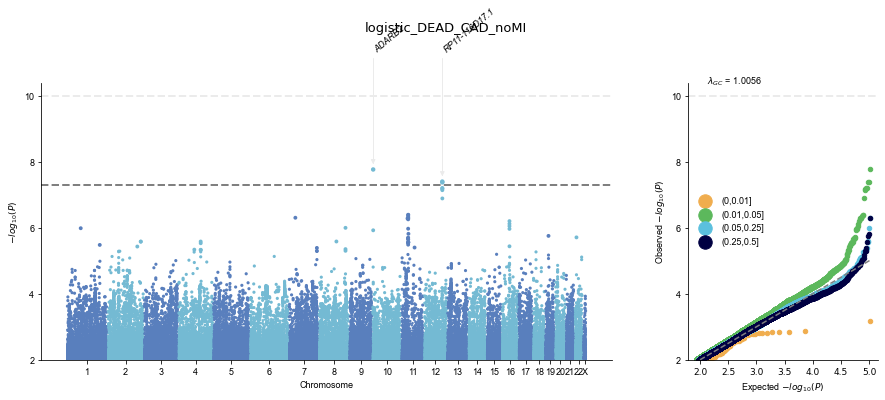

In [67]:
# manhattan and qq plot
gwas_data_sumstats.plot_mqq(
    skip=2,
    cut=10,
    sig_line=True,
    sig_level=5e-8,
    anno="GENENAME",
    anno_style="right",
    windowsizekb=500,
    arm_offset=2,
    repel_force=0.02,  # default 0.01
    use_rank=True,
    build="19",
    # mode="m",
    stratified=True,
    drop_chr_start=True,
    # figargs={"figsize": (25, 15), "dpi": 300},
    title="" + PHENOTYPE + "",
    save=os.path.join(PLOTS_loc, "manhattan.500kb.300dpi." + PHENOTYPE + ".pdf"),
    saveargs={"dpi": 300},
    verbose=True,
)

### Top loci

We inventory the top loci. 


In [68]:
gwas_data_sumstats.get_lead(anno=True, sig_level=5e-8, verbose=True)

Thu Nov  2 17:15:48 2023 Start to extract lead variants...
Thu Nov  2 17:15:48 2023  -Processing 9523593 variants...
Thu Nov  2 17:15:48 2023  -Significance threshold : 5e-08
Thu Nov  2 17:15:48 2023  -Sliding window size: 500  kb
Thu Nov  2 17:15:57 2023  -Found 3 significant variants in total...
Thu Nov  2 17:15:57 2023  -Identified 2 lead variants!
Thu Nov  2 17:15:57 2023  -Annotating variants using references:ensembl
Thu Nov  2 17:15:57 2023  -Annotating variants using references based on genome build:19
Thu Nov  2 17:15:57 2023 Start to annotate variants with nearest gene name(s)...
Thu Nov  2 17:15:57 2023  -Assigning Gene name using ensembl_hg19_gtf for protein coding genes
Thu Nov  2 17:15:58 2023 Finished annotating variants with nearest gene name(s) successfully!
Thu Nov  2 17:15:58 2023 Finished extracting lead variants successfully!


,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,STATUS,DF,DIRECTIONS,P_COCHRANS_Q,I_SQUARED,CAVEAT,rsID,LOCATION,GENE
5629908,10:2122415:C:A,10,2122415,A,C,0.012,1.0397,0.1844,1.710200e-08,9745,1960009,4,...+.++.+...+,0.46910,0.0,None,rs145350794,-342745,ADARB2
6960133,12:115969517:T:G,12,115969517,G,T,0.013,0.4992,0.0909,3.977100e-08,37565,1960009,9,++.++-+.+.-++,0.76337,0.0,None,rs189081093,-166967,RP11-116D17.1


### Targets

Get the targets for `PHENOTYPE` and compare to CAD GWAS ('Million Hearts') data.

In [69]:
import polars as pl

# polars.read_excel(
# source: str | BytesIO | Path | BinaryIO | bytes,
# *,
# sheet_id: None = None,
# sheet_name: str,
# engine: Literal['xlsx2csv', 'openpyxl', 'pyxlsb'] | None = None,
# xlsx2csv_options: dict[str, Any] | None = None,
# read_csv_options: dict[str, Any] | None = None,
# schema_overrides: SchemaDict | None = None,
# raise_if_empty: bool = True,
# )
# del target_variants
# del target_genes
# del target_cad

target_variants = pl.read_excel(
    source=os.path.join("targets/targets.xlsx"), sheet_name="Variants"
)

target_genes = pl.read_excel(
    source=os.path.join("targets/targets.xlsx"), sheet_name="Genes"
)

In [70]:
target_cad = pl.read_excel(
    source=os.path.join("targets/targets.xlsx"), sheet_name="CAD"
)

In [71]:
target_variants.head()

RSID,ALTID,VariantID,Chr,BP,VariantType,Comments
str,str,str,i64,i64,str,str
"""rs145350794""","""locus_1""","""10:2122415""",10,2122415,"""single nucleot…","""logistic_DEAD_…"
"""rs189081093""","""locus_2""","""12:115969517""",12,115969517,"""single nucleot…","""logistic_DEAD_…"
"""rs58365910""","""locus_3""","""15:78849034""",15,78849034,"""single nucleot…","""cox_DEAD_ALL"""
"""rs12441088""","""locus_4""","""15:78928264""",15,78928264,"""single nucleot…","""logistic_DEAD_…"
"""rs188559095""","""locus_5""","""16:83035073""",16,83035073,"""single nucleot…","""logistic_CVDEA…"


In [72]:
target_cad.head()

MarkerName,CHR,BP,Allele1,Allele2,Freq1,FreqSE,MinFreq,MaxFreq,Effect,StdErr,P-value,Direction,HetISq,HetChiSq,HetDf,HetPVal,Cases,Effective_Cases,N,Meta_analysis,SNPID,Index
str,i64,i64,str,str,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,i64,f64,i64,i64,i64,str,str,i64
"""1:2245570_C_G""",1,2245570,"""C""","""G""",0.28,0.0251,0.2305,0.3312,0.041638,0.005804,0.0,"""+++-+-+-+++""",16.6,11.985,10,0.286,173909,162434,1138550,"""Cardiogram""","""1:2245570:C:G""",1
"""1:2252205_C_T""",1,2252205,"""T""","""C""",0.1442,0.0169,0.1106,0.1746,0.046794,0.007375,0.0,"""+++++-+-+++""",0.0,7.516,10,0.676,174440,160990,1143770,"""Cardiogram""","""1:2252205:T:C""",2
"""1:2917460_C_G""",1,2917460,"""C""","""G""",0.8746,0.014,0.8548,0.9191,0.031473,0.007704,0.000044,"""++--+++-+-+""",19.4,12.411,10,0.2585,181522,177219,1165680,"""Cardiogram""","""1:2917460:C:G""",3
"""1:2985885_C_G""",1,2985885,"""C""","""G""",0.6118,0.0236,0.574,0.6404,-0.035136,0.005753,0.0,"""--????-?-?-""",0.0,3.435,4,0.4878,154611,138116,1100510,"""Cardiogram""","""1:2985885:C:G""",4
"""1:3325912_A_C""",1,3325912,"""A""","""C""",0.1404,0.0148,0.1207,0.207,0.04846,0.007234,0.0,"""+++++++-+++""",36.6,15.772,10,0.1064,176686,173914,1150900,"""Cardiogram""","""1:3325912:A:C""",5


Thu Nov  2 17:16:12 2023  -Skip saving figures!


[                     P_1  P_2 EA_1 NEA_1  EFFECT_1    SE_1 EA_2 NEA_2  \
 SNPID                                                                   
 1:2245570:C:G    0.46468  0.0    G     C    0.0186  0.0254    C     G   
 1:2985885:C:G    0.28595  0.0    G     C    0.0429  0.0402    C     G   
 1:55496039:T:C   0.43732  0.0    C     T   -0.0198  0.0255    T     C   
 1:56962821:A:G   0.63385  0.0    G     A    0.0154  0.0323    A     G   
 1:109817192:A:G  0.89553  0.0    G     A   -0.0031  0.0234    A     G   
 ...                  ...  ...  ...   ...       ...     ...  ...   ...   
 20:47433150:T:C  0.42774  0.0    C     T    0.0238  0.0301    T     C   
 20:57728889:A:C  0.54828  0.0    C     A   -0.0151  0.0252    A     C   
 22:19609256:A:G  0.98544  0.0    G     A    0.0004  0.0229    A     G   
 22:24555861:A:G  0.23208  0.0    G     A    0.0424  0.0355    A     G   
 22:43623972:A:G  0.70918  0.0    G     A   -0.0077  0.0207    A     G   
 
                  EFFECT_2      SE_2

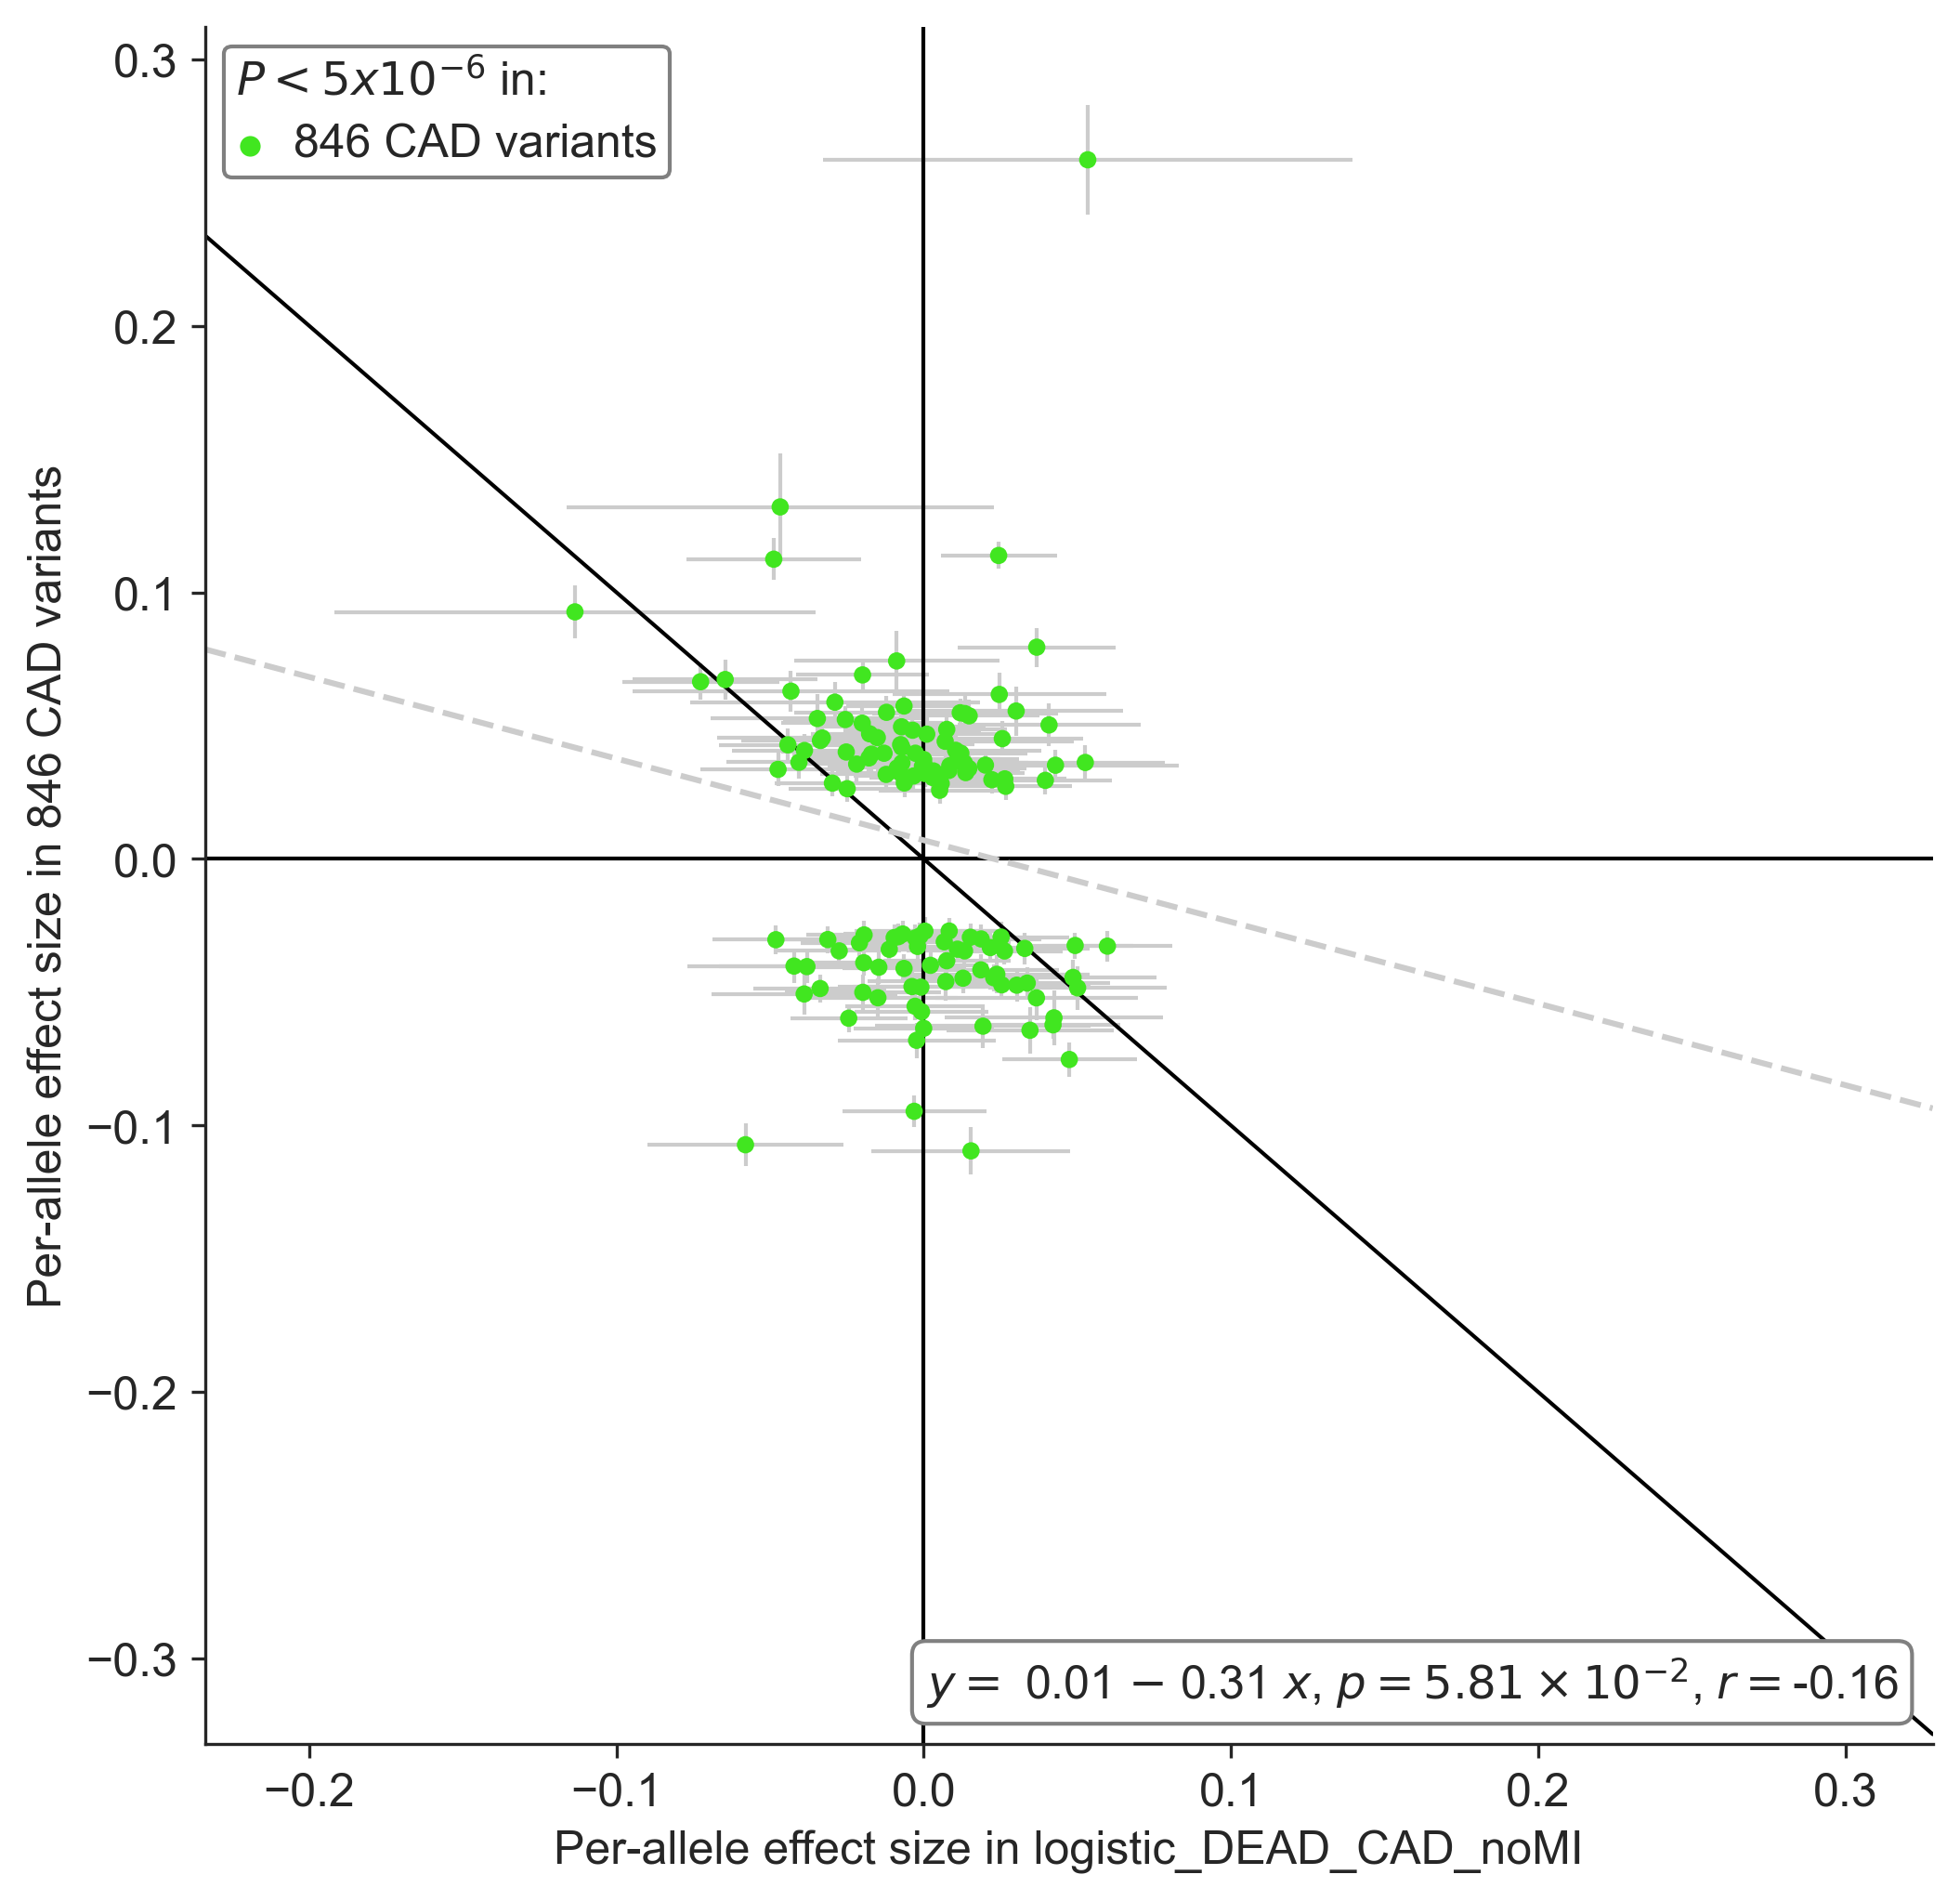

In [73]:
# https://cloufield.github.io/gwaslab/EffectSize/

gl.compare_effect(
    gwas_data_sumstats,
    target_cad.to_pandas(),
    cols_name_list_2=["SNPID", "P-value", "Allele1", "Allele2", "CHR", "BP"],
    effect_cols_list_2=["Effect", "StdErr"],
    mode="beta",
    label=[PHENOTYPE, "846 CAD variants", "Both", "None"],
    sig_level=5e-8,
    legend_title=r"$ P < 5 x 10^{-6}$ in:",
    legend_title2=r"Heterogeneity test:",
    legend_pos="upper left",
    #  legend_args=None,
    xylabel_prefix="Per-allele effect size in ",
    is_reg=True,
    is_45_helper_line=True,
    # anno=True,
    # anno_min=0,
    # anno_min1=0,
    # anno_min2=0,
    # anno_diff=0,
    # is_q=False,
    q_level=0.05,
    # anno_het=False,
    # r_se=False,
    #  fdr=False,
    #  legend_mode="full",
    # save=False,
    # saveargs=None,
    verbose=False,
)

In [74]:
# # https://cloufield.github.io/gwaslab/EffectSize/

# gl.compare_effect(
#     gwas_data_sumstats,
#     cad_data_sumstats,
#     mode="beta",
#     label=[PHENOTYPE, "Million Hearts", "Both", "None"],
#     sig_level=5e-8,
#     legend_title=r"$ P < 5 x 10^{-8}$ in:",
#     legend_title2=r"Heterogeneity test:",
#     legend_pos="upper left",
#     #  legend_args=None,
#     xylabel_prefix="Per-allele effect size in ",
#     is_reg=True,
#     is_45_helper_line=True,
#     # anno=True,
#     # anno_min=0,
#     # anno_min1=0,
#     # anno_min2=0,
#     # anno_diff=0,
#     # is_q=False,
#     q_level=0.05,
#     # anno_het=False,
#     # r_se=False,
#     #  fdr=False,
#     #  legend_mode="full",
#     # save=False,
#     # saveargs=None,
#     verbose=False,
# )